# Fine-tuning
In this file we will fine-tune Encoder models, like BERET, RoBERTa, etc., on the corpus of PAN. Then, evaluate them on the test set.

In [1]:
import torch
from transformers import BertTokenizer, DataCollatorWithPadding, utils
from transformers import AutoModelForSequenceClassification, BertForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np
import os
from bertviz import model_view
from bertviz import head_view
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy

from utilities import (read_paragraphs,
                       read_ground_truth, 
                       generate_dataset)
utils.logging.set_verbosity_error()  # Suppress standard warnings

In [2]:
# Due to the lack of the true test set. We use the validation set as our test set.
# We will split the training set into train and validation sets.
test_directory = './data/validation_processed'
test_label_directory = './data/validation_label'
checkpoint = "finetuned-bert-base-cased/sweep-1-checkpoint-225" 
device = torch.device('cuda' if torch.cuda.is_available() else  'cpu')
# File path to check
file_path = "classification_prob.npy"
file_exists = False
# Check if file exists
if os.path.isfile(file_path):
  file_exists = True
  print(f"File '{file_path}' exists.")
else:
  print(f"File '{file_path}' does not exist.")


File 'classification_prob.npy' exists.


In [3]:
# max(end_id) = 900
test_data = read_paragraphs(test_directory, start_id=1, end_id=900)
# Read ground truth labels
test_labels  = read_ground_truth(test_label_directory, start_id=1, end_id=900)

tokenizer = BertTokenizer.from_pretrained(checkpoint)
print(tokenizer.model_max_length)

test_dataset = generate_dataset(test_data, test_labels, tokenizer)

if not file_exists:
    def tokenize_function(example):
        return tokenizer(example["sentence1"], example["sentence2"], 
                        truncation=True)

    tokenized_datasets = test_dataset.map(tokenize_function, batched=True)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    print(tokenized_datasets)

512


In [4]:
if not file_exists:
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [5]:
if not file_exists:
    # Calculate classification logits
    batch_size=200
    class_logits = []
    model.to(device)
    with torch.no_grad():
        for batch in range(0, tokenized_datasets.num_rows, batch_size): # 
                input_ids = {k:v for k, v in tokenized_datasets[batch: batch + batch_size].items() if k not in ['sentence1', 'sentence2', 'idx']}
                batch_data = data_collator(input_ids)
                batch_data = {k:v.to(device) for k, v in batch_data.items()}
                outputs = model(**batch_data)
                print(outputs.keys(), outputs['logits'].shape)
                class_logits.append(outputs['logits'])
                # break

    concatenated_tensor = torch.cat(class_logits, dim=0)
    print(concatenated_tensor.shape)

In [6]:
if not file_exists:
    classification_prob = concatenated_tensor.detach().softmax(dim=1).cpu().numpy() # calculate classification probability
    # Save the ndarray to a file named "data.npy"
    np.save(file_path, classification_prob)
else:
    classification_prob = np.load(file_path)

print('F1-score:', multiclass_f1_score(torch.tensor(np.argmax(classification_prob, axis=1)), torch.tensor(test_dataset['label']), num_classes=2, average="macro"))
print('Accuracy:', multiclass_accuracy(torch.tensor(np.argmax(classification_prob, axis=1)), torch.tensor(test_dataset['label']), num_classes=2, average="macro"))

target_prob_np = classification_prob[range(len(test_dataset['label'])), test_dataset['label']] # get the probabilities of true labels
target_prob_np.shape

F1-score: tensor(0.7635)
Accuracy: tensor(0.7609)


/home/shiling/anaconda3/lib/python3.11/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:232.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


(4592,)

In [7]:
sorted_idx = np.argsort(target_prob_np)[::-1]
target_prob_np[sorted_idx[-3:]], target_prob_np[sorted_idx[:3]]

(array([0.06674169, 0.06331286, 0.06158699], dtype=float32),
 array([0.98601574, 0.98601574, 0.98601574], dtype=float32))

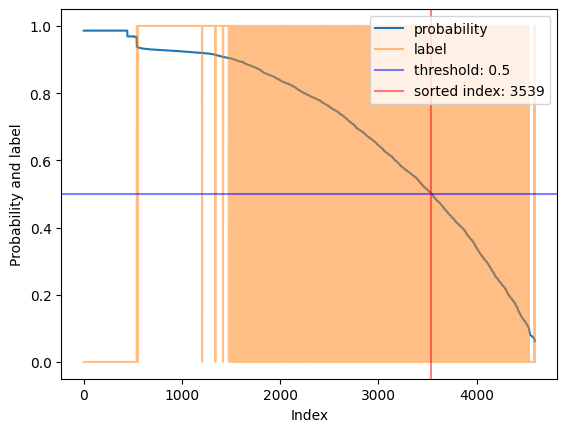

In [24]:
fig, ax = plt.subplots() 
ax.plot(target_prob_np[sorted_idx], label='probability') 
ax.plot(np.array(test_dataset['label'])[sorted_idx], alpha=0.5, label='label')

plt.axhline(0.5, color='blue',alpha=0.5, label='threshold: 0.5') # horizontal line, 水平线，alpha是指透明度
plt.axvline(3539, color='red',alpha=0.5, label='sorted index: 3539'); # vertical line, 垂直线，设置颜色

ax.set_xlabel('Index') 
ax.set_ylabel('Probability and label')
plt.legend(loc='upper right'); 
plt.show() 

# Attention visualization -- case study

In [9]:
# Enable returning attention scores
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, output_attentions=True)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
import matplotlib.pyplot as plt

def attention_views(text_idx, figsize=(10, 6)) :
    # input_texts = ["The cat sat on the mat" , "The cat sat on the mat" ]
    input_texts = [test_dataset['sentence1'][text_idx], test_dataset['sentence2'][text_idx]]
    label = test_dataset['label'][text_idx]
    print(f'True label: {label}, classification probability: {classification_prob[text_idx][label]}')
    print(input_texts[0])
    print(input_texts[1])
    inputs = tokenizer(input_texts[0], input_texts[1], return_tensors='pt')  # Tokenize input text
    inputs = {k:v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)  # Run model
    attention = outputs[-1][-1]  # Retrieve attention from model outputs, and select the attention of the last layer, torch.Size([1, 12, 8, 8])
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])  # Convert input ids to token strings
    # print(tokens)
    
    # Sample data (replace with your actual words and probabilities)
    words = tokens
    probabilities = torch.mean(attention[0,:,0,:], dim=0).cpu().detach().numpy()
    # print(probabilities)
    # Create the bar chart
    # How to make a plot with repeating labels on X axis? [duplicate]
    lab_x = [i for i in range(len(probabilities))]

    plt.figure(figsize=figsize)  # Adjust figure size as needed
    plt.bar(lab_x, probabilities, color='skyblue')
    plt.xticks(lab_x, words)

    # Set labels and title
    plt.xlabel("Tokens")
    plt.ylabel("Attention weights")
    plt.title("Attention view")

    # Rotate x-axis labels by 90 degrees (vertical orientation)
    plt.xticks(rotation=90)  # Simpler way to rotate 90 degrees vertically

    # Set grid for better visualization (optional)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

def head_views(text_idx) :
    # input_texts = ["The cat sat on the mat" , "The cat sat on the mat" ]
    input_texts = [test_dataset['sentence1'][text_idx], test_dataset['sentence2'][text_idx]]
    label = test_dataset['label'][text_idx]
    print(f'True label: {label}, classification probability: {classification_prob[text_idx][label]}')
    print(input_texts[0])
    print(input_texts[1])
    inputs = tokenizer(input_texts[0], input_texts[1], return_tensors='pt')  # Tokenize input text
    inputs = {k:v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)  # Run model
    attention = outputs[-1]  # Retrieve attention from model outputs
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])  # Convert input ids to token strings
    head_view(attention, tokens) 

## 1. The same author

True label: 0, classification probability: 0.9860157370567322
In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or troll accusations , hate speech , any suggestion or support of harm , violence , or death , and other rule violations can result in a permanent ban .
For those who have questions regarding any media outlets being posted on this subreddit , please click to review our details as to our approved domains list and outlet criteria .


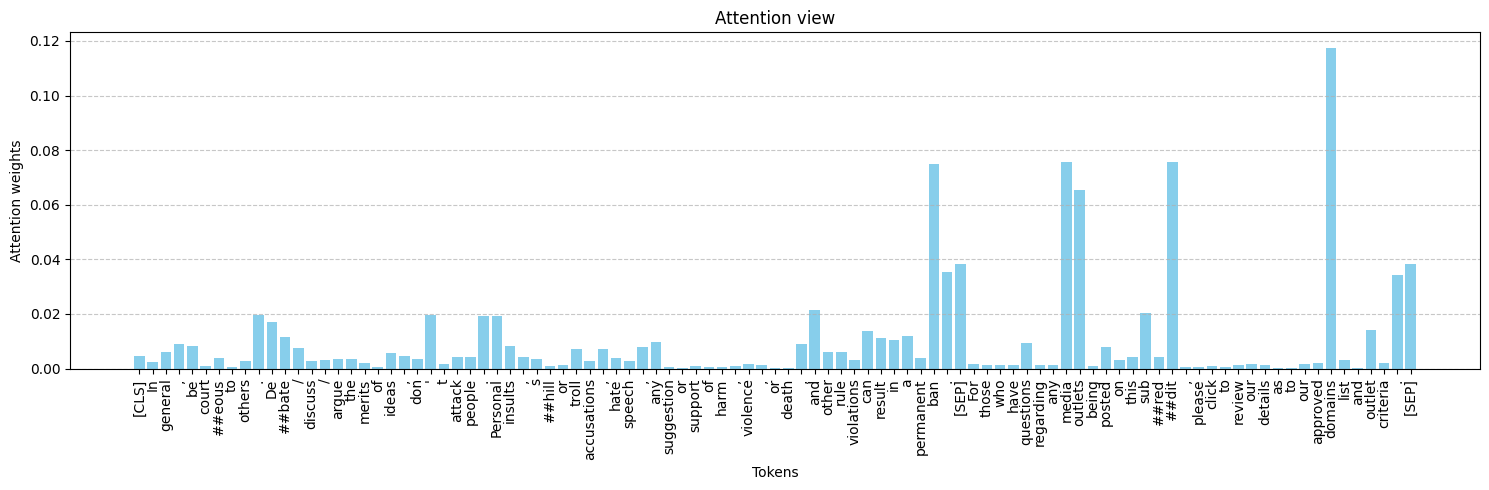

In [11]:
# True Negative
attention_views(sorted_idx[0], (15, 5))

True label: 0, classification probability: 0.9860157370567322
In general , be courteous to others . Debate / discuss / argue the merits of ideas , don ' t attack people . Personal insults , shill or troll accusations , hate speech , any suggestion or support of harm , violence , or death , and other rule violations can result in a permanent ban .
For those who have questions regarding any media outlets being posted on this subreddit , please click to review our details as to our approved domains list and outlet criteria .


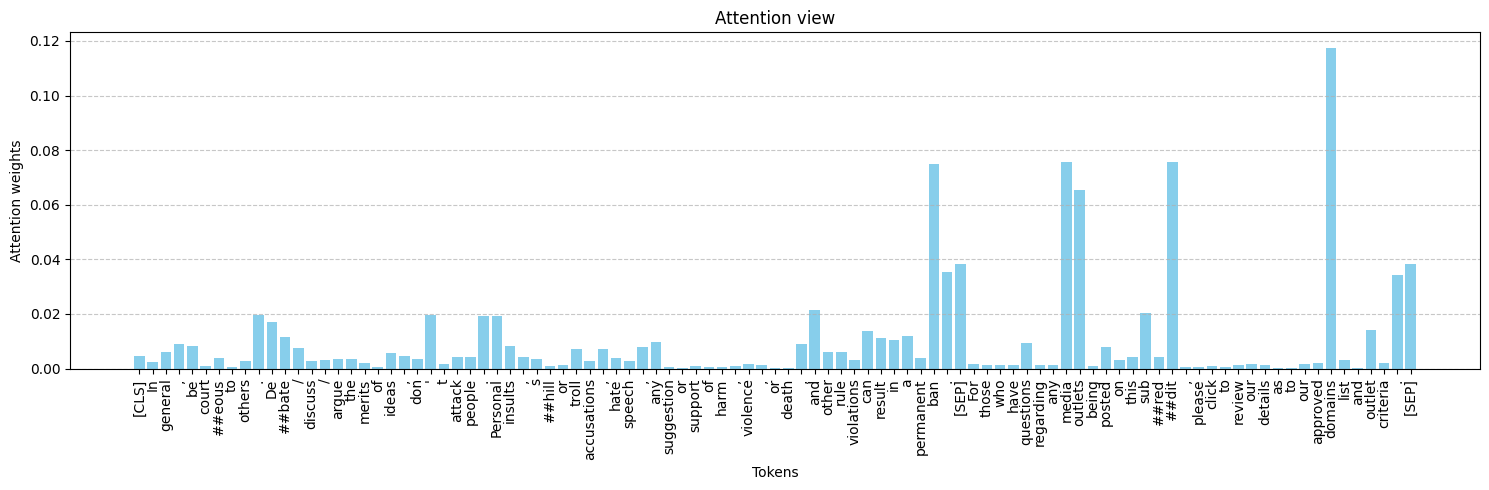

In [12]:
# True Negative
attention_views(sorted_idx[1], (15, 5))

True label: 0, classification probability: 0.33863162994384766
It ' s a moot point though isn ' t it ? If the Russian missiles were not fired at Ukraine then this would not have happened .
So while we obviously don ' t have a case for article 5 , the moral blame for the two Polish deaths ( and the terror that it ' s brought to eastern Poland ) is squarely on the doorstep of the Russian federation .


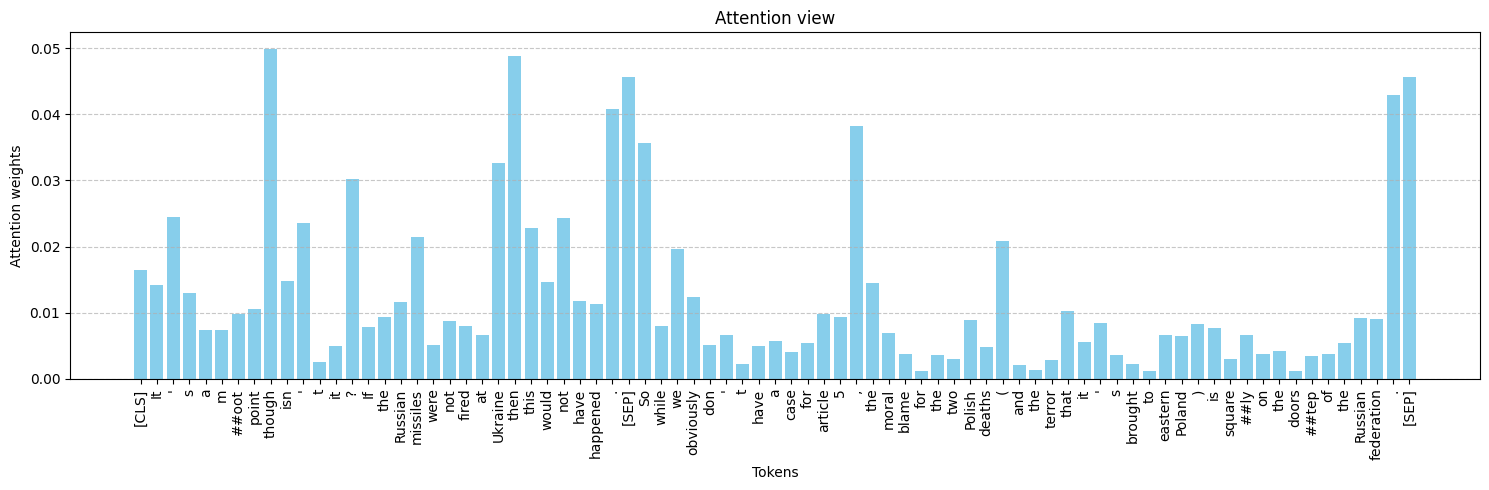

In [13]:
# False Positive
attention_views(sorted_idx[4001], (15, 5))

True label: 0, classification probability: 0.33799874782562256
Perhaps the people their take responsibility and the opportunity to make their country better now that the dictator died ? Nope . Got to blame everyone else for their problems since they want to keep things the old ways .
We have to be careful what we do because action can have great consequences even if their intention was positive .


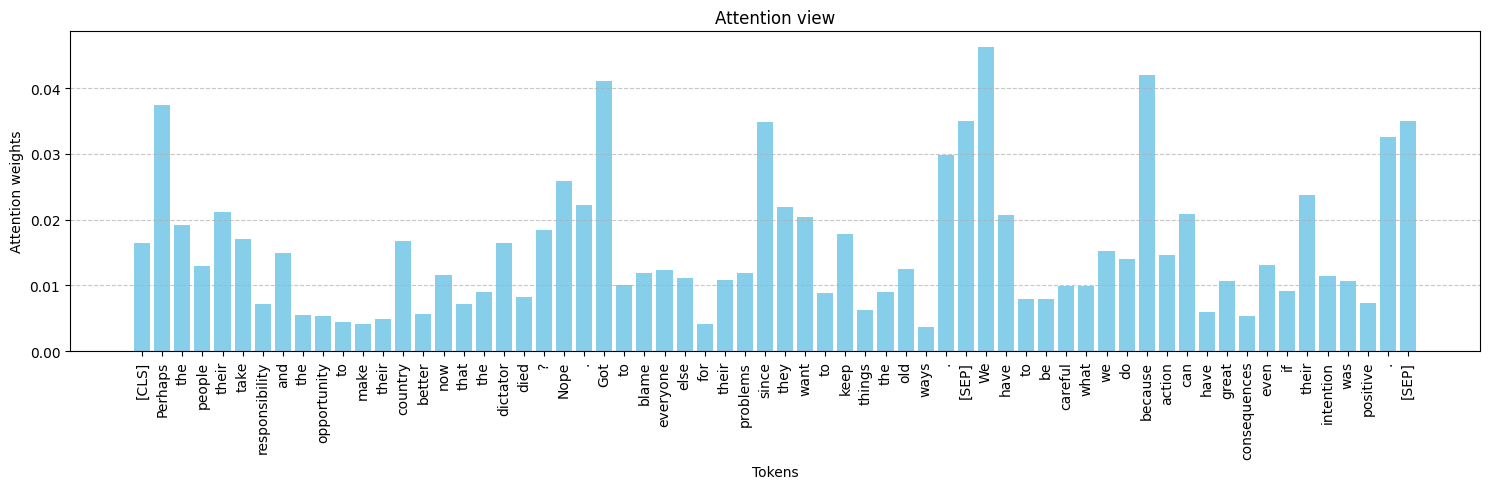

In [14]:
# False Positive
attention_views(sorted_idx[4003], (15, 5))

## 2. Different Author

True label: 1, classification probability: 0.9242424964904785
Interesting historical note : most of you are probably too young to remember this , but conservatives went through a similar phase briefly in the late 90s over a misunderstanding of something Silkk the Shocker said on stage . They were all suddenly sagging their pants and calling Bill Clinton wack .
I am a bot , and this action was performed automatically . Please if you have any questions or concerns .


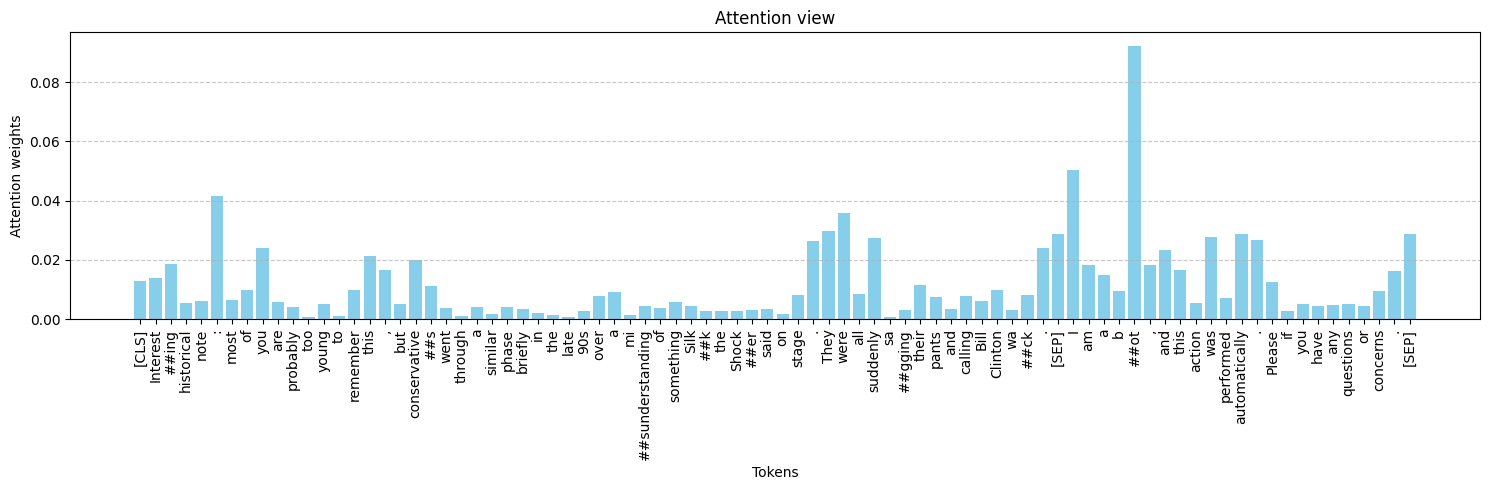

In [15]:
# True Positive
attention_views(sorted_idx[999], (15, 5))

True label: 1, classification probability: 0.9242066740989685
For those who have questions regarding any media outlets being posted on this subreddit , please click to review our details as to our approved domains list and outlet criteria .
A lot of Fox News ’ revenue comes from the fact that it is bundled in most cable packages as “ basic cable . ” So if you subscribe to a cable service , you are bankrolling Fox News even if you don ’ t watch it . It ’ s fair to criticize Hulu on this one , since it ’ s a similar idea .


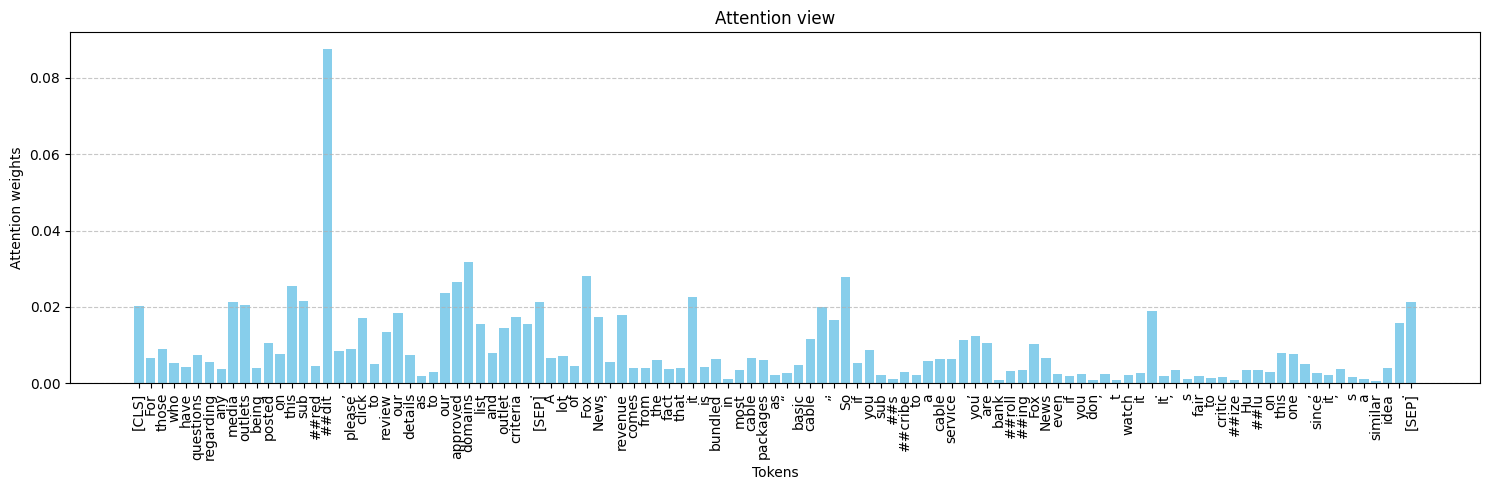

In [16]:
# True Positive
attention_views(sorted_idx[1000], (15, 5))

True label: 0, classification probability: 0.3367001712322235
He couldn ’ t stop if he wanted to , and won ’ t stop because he ’ s rewarded and validated for being a hate preacher every day .
For one , Reagan was really hawkish when it came to Russia . For two , Tucker is portraying on TV what he thinks the MAGA base want to hear , not what he actually thinks .


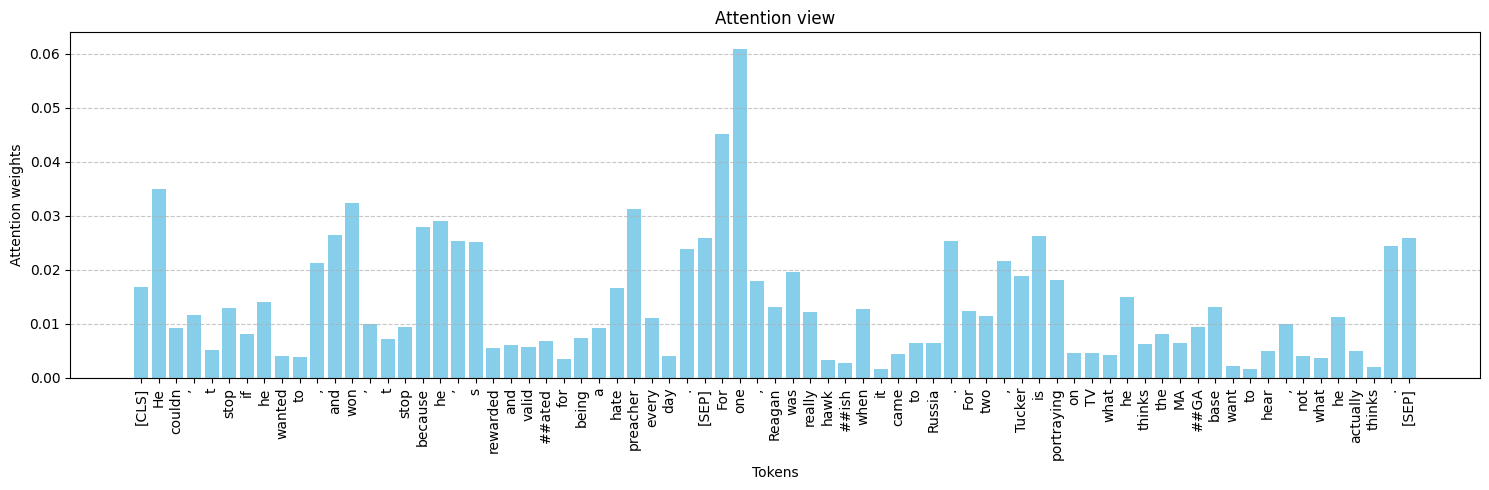

In [17]:
# False Negative
attention_views(sorted_idx[4004], (15, 5))

True label: 1, classification probability: 0.3385980427265167
Fact is Russian oil was irrelevant for Europe all the time . Oil is very easy to transport . What would really hurt Russia is a price cap and the ban of gas . In the contrary to oil , gas is much more difficult to transport it without pipelines .
Germany on Wednesday shrugged off Russia ’ s ban on oil sales to countries and companies that comply with a price cap agreed by Western allies , saying it has “ no practical significance . ” .


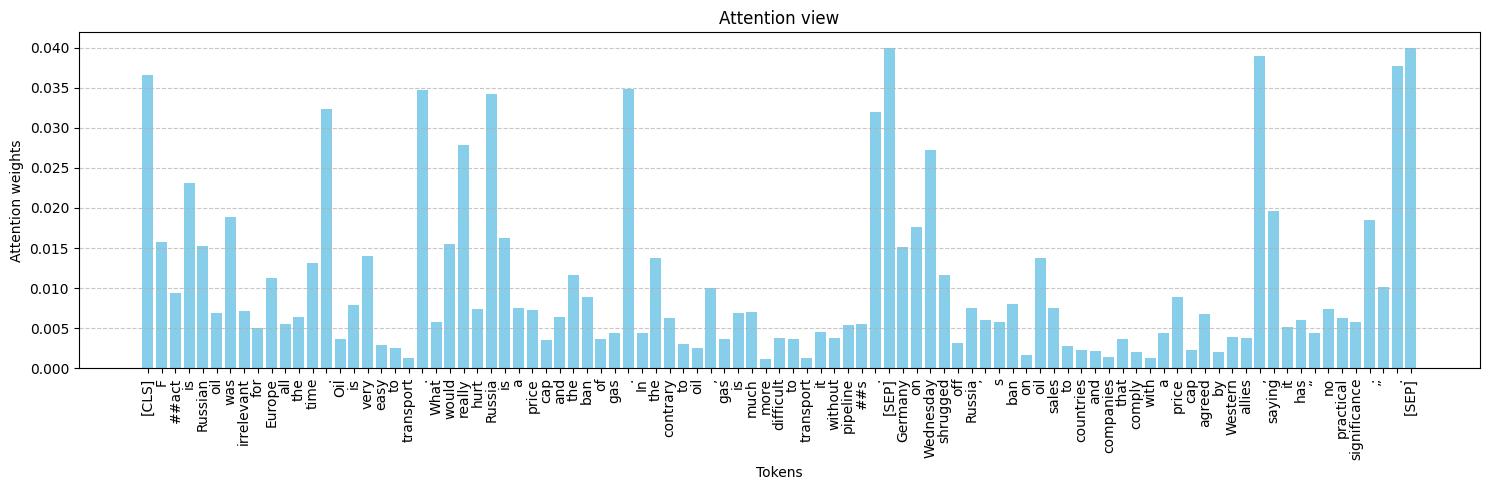

In [18]:
# False Negative
attention_views(sorted_idx[4002], (15, 5))

## More details

# Attention statistics

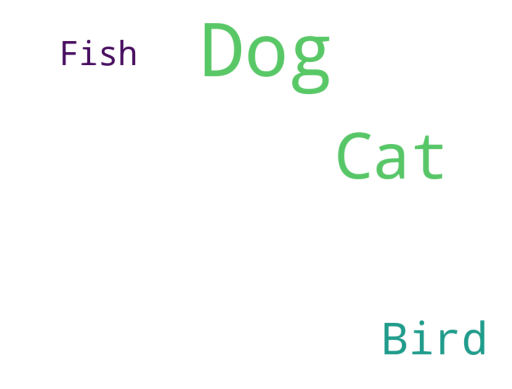

In [29]:
from wordcloud import WordCloud, STOPWORDS
word_freqs = {"Cat": 0.5, "Dog": 0.7, "Bird": 0.2, "Fish": 0.1}

def draw_word_cloud(word_freqs, width=800, height=600):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color='white', width=width, height=height,
                        stopwords=stopwords, max_font_size=120,
                        random_state=42)
    wordcloud.generate_from_frequencies(word_freqs)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

draw_word_cloud(word_freqs)


In [ ]:
# Calculate the accumulated attention weights of each word in the True Positive samples, 
# the True Negative samples, the False Positive samples and the False Negative samples
from collections import defaultdict 
TP_word_attention = defaultdict(lambda: 0)
TN_word_attention = defaultdict(lambda: 0)
FP_word_attention = defaultdict(lambda: 0)
FN_word_attention = defaultdict(lambda: 0)

for i, idx in enumerate(sorted_idx):
    # input_texts = ["The cat sat on the mat" , "The cat sat on the mat" ]
    input_texts = [test_dataset['sentence1'][idx], test_dataset['sentence2'][idx]]
    label = test_dataset['label'][idx]
    inputs = tokenizer(input_texts[0], input_texts[1], return_tensors='pt')  # Tokenize input text
    inputs = {k:v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)  # Run model
    attention = outputs[-1][-1]  # Retrieve attention from model outputs, and select the attention of the last layer, torch.Size([1, 12, 8, 8])
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])  # Convert input ids to token strings
    # print(outputs['logits'], outputs['logits'].softmax(dim=1), label, outputs['logits'].softmax(dim=1)[0, label])
    target_prob = outputs['logits'].softmax(dim=1)[0, label]
    attention_score = torch.mean(attention[0,:,0,:], dim=0).cpu().detach().numpy()

    def record_attention(word_dic, tokens, attention):
        for i, token in enumerate(tokens):
            word_dic[token] += attention[i]
        
    if target_prob > 0.5 and label == 1: # True Positive
        record_attention(TP_word_attention, tokens, attention_score)
    elif target_prob > 0.5 and label == 0: # True Negative
        record_attention(TN_word_attention, tokens, attention_score)
    elif target_prob <= 0.5 and label == 1: # False Negative
        record_attention(FN_word_attention, tokens, attention_score)
    elif target_prob <= 0.5 and label == 0: # False Positive
        record_attention(FP_word_attention, tokens, attention_score)
            

In [55]:
def print_top_x(dic, top_x):
    # Sort the dictionary by values in descending order using a custom function
    sorted_dict = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))
    for i, key in enumerate(sorted_dict):
        print(key, '\t',sorted_dict[key])  
        if i >= top_x - 1:
            break

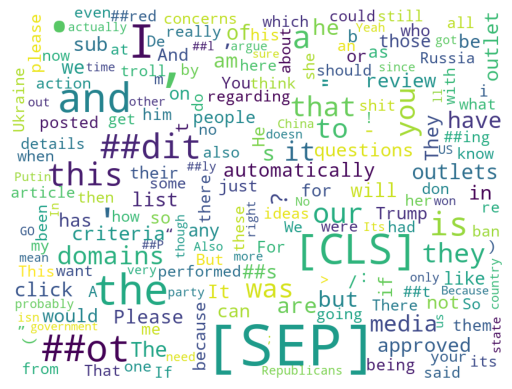

. 	 167.4734497831887
, 	 94.86395990705205
[SEP] 	 93.40068191476166
I 	 57.813280198635766
the 	 47.46246297322796
[CLS] 	 46.415406024549156
and 	 44.55731700099932
##ot 	 35.89060762448935
' 	 35.70909881783882
##dit 	 29.61718268317054
is 	 27.62739418689307
a 	 25.68937105214718
this 	 25.277828545178636
our 	 20.789035128924297
to 	 19.461570230290818
that 	 19.457449499474023
you 	 19.452521372179035
they 	 17.4598463204602
it 	 17.28755074874789
was 	 16.95917659587576


In [58]:
# detected authorship changing
draw_word_cloud(TP_word_attention) 
print_top_x(TP_word_attention, 20)


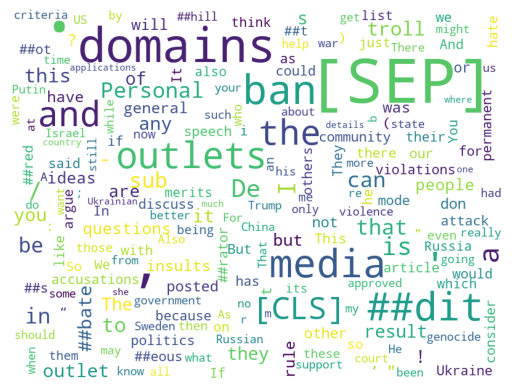

. 	 136.95059240591945
[SEP] 	 91.40084781497717
, 	 71.5770951979357
domains 	 52.068304389715195
ban 	 36.93362002156209
##dit 	 34.09114568674704
media 	 33.873360297468025
outlets 	 29.071710263378918
the 	 25.726055548599106
and 	 25.59077090350911
' 	 25.54157382855192
[CLS] 	 20.031302467919886
a 	 17.16058107450226
is 	 13.429125950613525
De 	 12.533262207522057
/ 	 12.477814956917427
I 	 11.68887940334389
that 	 9.589472178602591
can 	 9.467133624406415
Personal 	 9.38156623672694


In [59]:
# detected authorship consistency
draw_word_cloud(TN_word_attention)
print_top_x(TN_word_attention, 20)

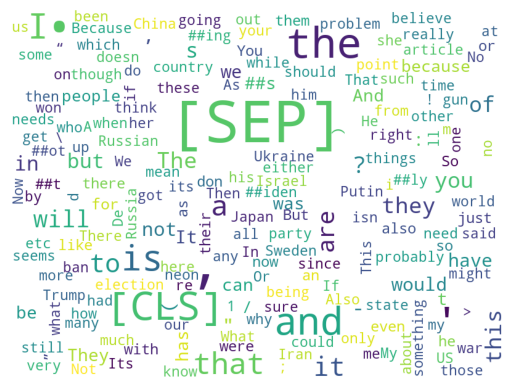

. 	 40.664923859905684
[SEP] 	 23.23890800587833
, 	 22.21589791693259
the 	 10.480086049705278
' 	 9.047585832944605
[CLS] 	 8.913691479247063
and 	 8.557238190231146
I 	 7.488814645214006
is 	 7.230483911000192
that 	 5.194088288524654
a 	 4.732316373556387
it 	 3.8951968398177996
to 	 3.7642758769361535
are 	 3.2294282661750913
will 	 3.0825545755506027
they 	 2.754428755491972
The 	 2.7473278081743047
this 	 2.676219967077486
? 	 2.661216819891706
of 	 2.541157166575431


In [60]:
# undetected authorship changing
draw_word_cloud(FN_word_attention)
print_top_x(FN_word_attention, 20)

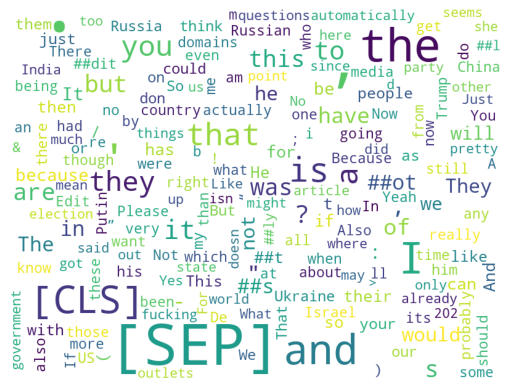

. 	 47.81109861814184
, 	 29.80896865852992
[SEP] 	 26.715062947478145
the 	 16.164496437384514
I 	 14.881946680136025
and 	 13.12773884939088
' 	 12.068650128203444
[CLS] 	 11.119766546413302
is 	 8.963610737991985
a 	 7.331585881292995
that 	 7.297471958503593
you 	 6.2835533824400045
they 	 5.77888093481306
it 	 5.232538778567687
to 	 5.029893296872615
but 	 4.346339540556073
’ 	 4.3021432146197185
? 	 4.207943247398362
are 	 4.029774398281006
this 	 3.990466001792811


In [61]:
# undetected authorship consistency
draw_word_cloud(FP_word_attention)
print_top_x(FP_word_attention, 20)